##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer Timeseries

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> on a time series data sequence. This is an advanced example that assumes knowledge of [attention](https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention) and [transformer](https://www.tensorflow.org/alpha/tutorials/text/transformer).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

In [1]:
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)

#!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

import random
import math

import os
import copy
!pip install pandas
import pandas as pd
from pandas import Series
!pip install sklearn
from sklearn import preprocessing
!pip install ipdb
import ipdb

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Prepare Dataset

We will use a txt file containing sequential time series data. No time is given just a single column containing numbers.

(39244, 1)
./test_data/time_series_data.txt


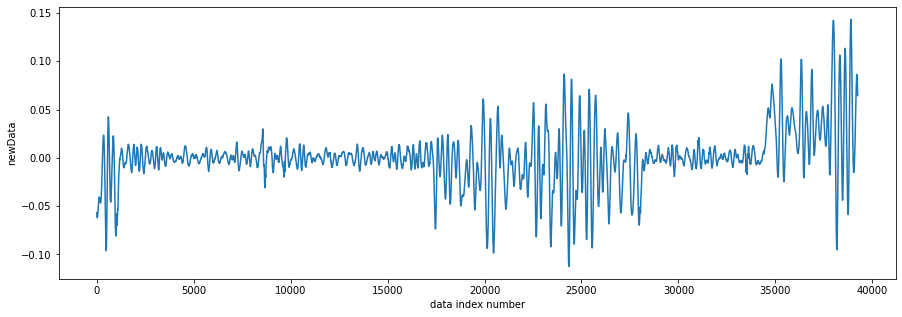

In [2]:
## The test data
path_to_data =  r'./test_data/time_series_data.txt'
newData = pd.read_csv(path_to_data, delimiter=',')
print(newData.shape)

newData = np.squeeze(newData.to_numpy()) # Convert to numpy array remove 1 length dimensions
tdata_len = len(newData)

plt.figure(figsize=(15,5))

plt.plot(newData)
plt.xlabel("data index number")
plt.ylabel("newData")

print(path_to_data)

### Load and preprocess data

#### Generate the input and output sequences

testData = 
 [-0.0567 -0.0571 -0.0573 ...  0.0667  0.0657  0.0646]
testData length = 39244
input_seq length = 218
output_seq length = 218
input_seq = 
 [[-0.0185 -0.0182 -0.0179 ...  0.0649  0.0661  0.0673]
 [-0.0486 -0.0479 -0.0472 ... -0.0352 -0.035  -0.0348]
 [ 0.0008  0.0008  0.0007 ...  0.0096  0.0097  0.0098]
 ...
 [ 0.04    0.0399  0.0397 ... -0.0454 -0.0467 -0.048 ]
 [ 0.0037  0.0039  0.0041 ...  0.0005  0.0001 -0.0002]
 [-0.0004 -0.0004 -0.0002 ...  0.0044  0.0046  0.0048]]
output_seq = 
 [[ 0.0685  0.0697  0.0708 ...  0.0862  0.0853  0.0844]
 [-0.0346 -0.0344 -0.0341 ...  0.0056  0.0056  0.0056]
 [ 0.0098  0.0098  0.0098 ... -0.0043 -0.0047 -0.0051]
 ...
 [-0.0493 -0.0506 -0.0518 ... -0.0933 -0.0929 -0.0925]
 [-0.0006 -0.0009 -0.0013 ... -0.0066 -0.0064 -0.0063]
 [ 0.0049  0.0052  0.0053 ... -0.0004 -0.0005 -0.0007]]


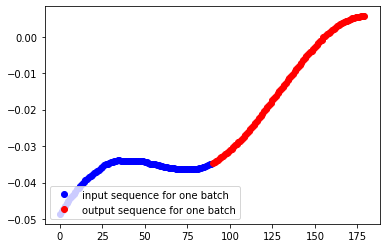

In [23]:
in_seq_len = 90
out_seq_len = 90
noise_factor = 0.0


# step_period = 0.01 # data is taken at 100 Hz
# max_time = tdata_len * step_period 
# print("tdata_len = ",tdata_len)
# print("max_time = ",max_time)
# min_time = 0
# newDataTime = np.arange(min_time,max_time, step_period)
# print("newDataTime = \n",newDataTime)
# x = np.linspace(0, max_time, tdata_len)

def true_signal(x, y_data):
    
    y = y_data[x]
    return y

def noise_func(x, noise_factor = 0.0):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x, y_data, noise_factor = 1):
    # For each array in x generate a corresponding output array y from the y_data array input.
    return true_signal(x, y_data) + noise_func(x, noise_factor)


def generate_train_samples(input_y, batch_size = 10, 
                           input_seq_len = in_seq_len, output_seq_len = out_seq_len):
    # input_y is an array e.g the data to learn
    
    # create an index array
    input_x = np.arange(0,len(input_y))
    assert len(input_x) == len(input_y)
    
    total_start_points = len(input_x) - input_seq_len - output_seq_len
    #print("total_start_points = ", total_start_points)
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    #print("start_x_idx = \n", start_x_idx)
    
    input_seq_x = [input_x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [input_x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    #print("input_seq_x = \n", input_seq_x)
    #print("output_seq_x = \n", output_seq_x)
    
    #ipdb.set_trace()
    input_seq_y = [generate_y_values(x, input_y, noise_factor) for x in input_seq_x]
    output_seq_y = [generate_y_values(x, input_y, noise_factor) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)

testData = newData.flatten()
print("testData = \n",testData)
print("testData length = {}".format(len(testData)))


len_testData = len(testData)
len_batch = in_seq_len + out_seq_len
input_seq, output_seq = generate_train_samples(testData, batch_size=math.floor(len_testData/len_batch))
print("input_seq length = {}".format(len(input_seq)))
print("output_seq length = {}".format(len(output_seq)))
print("input_seq = \n",input_seq)
print("output_seq = \n",output_seq)

l1, = plt.plot(range(in_seq_len), input_seq[1], 'bo', label = 'input sequence for one batch')
plt_start = in_seq_len
plt_end = in_seq_len + out_seq_len
l2, = plt.plot(range(plt_start, plt_end), output_seq[1], 'ro', label = 'output sequence for one batch')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

In [24]:
class preprocess_data():
    """
        Preprocess the input and output data so the attention RNN can use it. 
        The attention RNN requires the input to be integers with a known range.
        
        The input and output are also broken up into small chunks. 
        Each input chunk has a corresponding output chunk that will be used to train on.
    """

    def __init__(self, input_array, output_array, num_buckets=10000, chunk_size_in=10, chunk_size_out=10):
        self.num_buckets = num_buckets
        self.chunk_size_in = chunk_size_in
        self.chunk_size_out = chunk_size_out
        self.input_array = input_array
        self.output_array = output_array
        # Normalise the input and output data
        self.normalized_in, self.scaler_in = self._normalise_data(input_array)
        self.normalized_out, self.scaler_out = self._normalise_data(output_array)
        # Discretise the data
        self.discrete_in = self._discretise(self.normalized_in, self.num_buckets) 
        self.discrete_out = self._discretise(self.normalized_out, self.num_buckets) 
        # Divide the input and output up into chunks
        self.input_chunks = self._chunkify(self.discrete_in, self.chunk_size_in)
        self.output_chunks = self._chunkify(self.discrete_out, self.chunk_size_out)
        
    def _chunkify(self, input_data_array, chunk_size):
        # Divide the input evenly by the chunk size. Delete the modulus of the division so the input is evenly divided by the chunks.
        num_chunks = math.floor(len(input_data_array) / chunk_size)
        remainder = len(input_data_array) % chunk_size
        discrete_in = input_data_array[0:-remainder]
        in_chunks = discrete_in.reshape(num_chunks, chunk_size)
        #print("in_chunks shape = ", in_chunks.shape)
        return in_chunks
        
    # normalise the data (range 0 to 1)
    def _normalise_data(self, input_data_array, scaler=None):
        series = Series(input_data_array)
        #print("Orig input shape = %s data %s \n" %(input_data_array.shape, series.values))
        # prepare data for normalization
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        if scaler is None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
            scaler = scaler.fit(values)
        #print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)

        # inverse transform and print
        inversed = scaler.inverse_transform(normalized)

        normalized = normalized.reshape(len(values))
        #print("Normalised data shape = %s  data = %s \n" % (normalized.shape, normalized))
        #print("inversed normalised data (orig) \n %s" % inversed)

        return normalized, scaler

    # Apply the inverse of normalisation process to get the original data
    def _un_normalise_data(self, normalised_input_array, scaler):
        series = Series(normalised_input_array)
        values = series.values
        values = normalised_input_array.reshape((len(values), 1))
        inversed = scaler.inverse_transform(values)
        return inversed


    def _discretise(self, in_array, nbuckets):
        # Change the input from 0 to 1 range to a 0 to num_buckets range.
        # Since the embedding layer needs an integer we convert the input using the 
        # number of buckets to be an integer in the range of 0 to num_buckets. 
        # Think of this as us discretizing the input. 
        #print(type(normalized_in))
        discrete_in = ((nbuckets-1)*in_array).astype(int)
        return discrete_in
    
    def _un_discretise(self, in_array, nbuckets):
        in_array = np.array(in_array)
        in_array = in_array.astype(float)
        undiscrete = np.divide(in_array, (nbuckets-1))
        return undiscrete
        
    def preprocess_input(self, indata_array):
        # Normalise the input data
        #import ipdb; ipdb.set_trace()
        normalized_in, scaler_in = self._normalise_data(indata_array, scaler=self.scaler_in)
        # Discretise the data
        discrete_in = self._discretise(normalized_in, self.num_buckets) 
        return discrete_in
    
    def preprocess_output(self, outdata_array):
        # Normalise the output data
        #import ipdb; ipdb.set_trace()
        normalized_out, scaler_out = self._normalise_data(outdata_array, scaler=self.scaler_out)
        # Discretise the data
        discrete_out = self._discretise(normalized_out, self.num_buckets) 
        return discrete_out
        
    def un_preprocess_input(self, indata_array):
        # Un process the input data. ie. apply the inverse operations that the processing 
        # class has applied to the input data
        un_in = self._un_discretise(indata_array, self.num_buckets)
        un_in = self._un_normalise_data(un_in, self.scaler_in)
        return un_in
            
    def un_preprocess_output(self, outdata_array):
        # Un process the output data. ie. apply the inverse operations that the processing 
        # class has applied to the output data
        un_in = self._un_discretise(outdata_array, self.num_buckets)
        un_in = self._un_normalise_data(un_in, self.scaler_out)
        return un_in

In [25]:
# Discretise the input/output into buckets and turn them into smaller chunks to learn on.
num_buckets=10000  # This means the largest value of the preprocessed data is num_buckets-1. 
chunk_size_in = 11 # This corresponds to chunk_size * in_period seconds of input data
chunk_size_out = 11 # This corresponds to chunk_size * in_period seconds of output data
input_array = input_seq.flatten()
output_array = output_seq.flatten()
print("input_array shape = ", input_array.shape)
print("output_array shape = ", output_array.shape)

prep_data = preprocess_data(input_array, output_array, num_buckets, chunk_size_in, chunk_size_out)
discrete_in = prep_data.discrete_in
discrete_out = prep_data.discrete_out
# Break the input sin wave up into chunks.
# The RNN with attention will attempt to predict the next chunk from the input chunk.
input_chunks = prep_data.input_chunks
output_chunks = prep_data.output_chunks

print("input_chunks shape = ", input_chunks.shape)
print("output_chunks shape = ", output_chunks.shape)

print("input_chunks[1] = ", input_chunks[1])
print("output_chunks[1] = ", output_chunks[1])

input_array shape =  (19620,)
output_array shape =  (19620,)
input_chunks shape =  (1783, 11)
output_chunks shape =  (1783, 11)
input_chunks[1] =  [3351 3372 3393 3419 3444 3465 3491 3516 3546 3571 3601]
output_chunks[1] =  [8292 8338 8389 8435 8477 8519 8565 8602 8648 8685 8717]


In [26]:
# Build tokenizer using tfds for both questions and answers
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     input_chunks + output_chunks, target_vocab_size=num_buckets)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [num_buckets], [num_buckets + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = num_buckets + 2

In [27]:
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('START_TOKEN, END_TOKEN: ', START_TOKEN, END_TOKEN)


VOCAB_SIZE:  10002
START_TOKEN, END_TOKEN:  [10000] [10001]


In [28]:
# Maximum sentence length
MAX_LENGTH = 40

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        #import ipdb; ipdb.set_trace()
        sentence1 = np.concatenate((START_TOKEN, sentence1, END_TOKEN))
        sentence2 = np.concatenate((START_TOKEN, sentence2, END_TOKEN))
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs


input_chunks_pad, output_chunks_pad = tokenize_and_filter(input_chunks, output_chunks)

In [29]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(input_chunks_pad)))

# Some inputs and outputs may have been revoed after the filtering.
print('Sample input_chunks: {}'.format(input_chunks[19]))
print('Sample output_chunks: {}'.format(output_chunks[19]))
print('Sample input_chunks_pad: {}'.format(input_chunks_pad[19]))
print('Sample output_chunks_pad: {}'.format(output_chunks_pad[19]))

Vocab size: 10002
Number of samples: 1783
Sample input_chunks: [4021 4021 4025 4025 4025 4025 4025 4030 4025 4025 4025]
Sample output_chunks: [5054 5054 5050 5054 5054 5054 5054 5050 5050 5045 5045]
Sample input_chunks_pad: [10000  4021  4021  4025  4025  4025  4025  4025  4030  4025  4025  4025
 10001     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Sample output_chunks_pad: [10000  5054  5054  5050  5054  5054  5054  5054  5050  5050  5045  5045
 10001     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


### Create `tf.data.Dataset`

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': input_chunks_pad,
        'dec_inputs': output_chunks_pad[:, :-1]
    },
    {
        'outputs': output_chunks_pad[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [32]:
print(input_chunks_pad[:, :-1])
print(output_chunks_pad[:, :-1])
print(output_chunks_pad[:, 1:])

[[10000  3173  3185 ...     0     0     0]
 [10000  3351  3372 ...     0     0     0]
 [10000  3627  3656 ...     0     0     0]
 ...
 [10000  4089  4089 ...     0     0     0]
 [10000  4085  4081 ...     0     0     0]
 [10000  4072  4076 ...     0     0     0]]
[[10000  7728  7783 ...     0     0     0]
 [10000  8292  8338 ...     0     0     0]
 [10000  8759  8791 ...     0     0     0]
 ...
 [10000  4819  4819 ...     0     0     0]
 [10000  4814  4805 ...     0     0     0]
 [10000  4717  4698 ...     0     0     0]]
[[7728 7783 7834 ...    0    0    0]
 [8292 8338 8389 ...    0    0    0]
 [8759 8791 8824 ...    0    0    0]
 ...
 [4819 4819 4823 ...    0    0    0]
 [4814 4805 4800 ...    0    0    0]
 [4717 4698 4689 ...    0    0    0]]


## Attention



### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [33]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [34]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Transformer

### Masking



`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [35]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [36]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [37]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [38]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [39]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

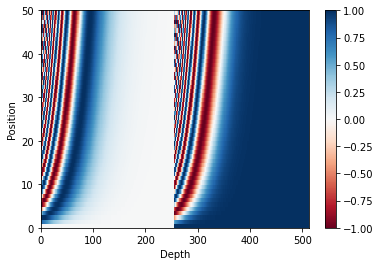

In [40]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [41]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [42]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [43]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [44]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [45]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [46]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [47]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [48]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [49]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [50]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Train model

### Initialize model

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [51]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [52]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [53]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

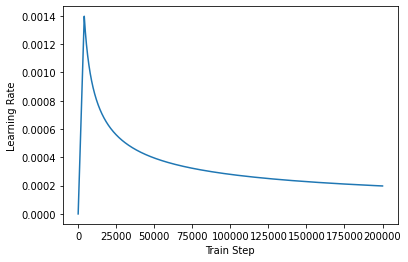

In [54]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [55]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### Fit model

Train our transformer by simply calling `model.fit()`

In [73]:
EPOCHS = 60

model.fit(dataset, epochs=EPOCHS)

Epoch 1/60
28/28 [==============================] - 2s 77ms/step - loss: 1.5488 - accuracy: 0.0489
Epoch 2/60
28/28 [==============================] - 2s 77ms/step - loss: 1.4775 - accuracy: 0.0563
Epoch 3/60
28/28 [==============================] - 2s 77ms/step - loss: 1.4073 - accuracy: 0.0630
Epoch 4/60
28/28 [==============================] - 2s 77ms/step - loss: 1.3402 - accuracy: 0.0695
Epoch 5/60
28/28 [==============================] - 2s 77ms/step - loss: 1.2775 - accuracy: 0.0750
Epoch 6/60
28/28 [==============================] - 2s 77ms/step - loss: 1.2197 - accuracy: 0.0807
Epoch 7/60
28/28 [==============================] - 2s 77ms/step - loss: 1.1657 - accuracy: 0.0874
Epoch 8/60
28/28 [==============================] - 2s 78ms/step - loss: 1.1172 - accuracy: 0.0928
Epoch 9/60
28/28 [==============================] - 2s 77ms/step - loss: 1.0711 - accuracy: 0.0989
Epoch 10/60
28/28 [==============================] - 2s 78ms/step - loss: 1.0279 - accuracy: 0.1050
Epoch 11/

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [74]:
def evaluate(sentence):
  #sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      np.concatenate((START_TOKEN, sentence, END_TOKEN)), axis=0)
  #import ipdb; ipdb.set_trace()
  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(prediction))

  return prediction

Let's test our model!

In [88]:
print("input_chunks[1] = {}".format(input_chunks[1]))
print("output_chunks[1] = {}".format(output_chunks[1]))
test_input = np.array([3380, 3394, 3386, 3449, 3454, 3465, 3411, 3516, 3546, 3572, 3601])
output = predict(test_input)

input_chunks[1] = [3351 3372 3393 3419 3444 3465 3491 3516 3546 3571 3601]
output_chunks[1] = [8292 8338 8389 8435 8477 8519 8565 8602 8648 8685 8717]
Input: [3380 3394 3386 3449 3454 3465 3411 3516 3546 3572 3601]
Output: [10000  8292  8338  8389  8435  8477  8519  8565  8602  8648  8685  8717]


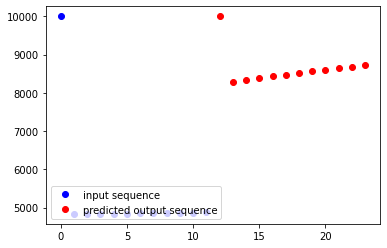

In [91]:
test_input_len = len(test_input)
l1, = plt.plot(range(test_input_len), test_input, 'bo', label = 'input sequence')
plt_start = test_input_len
plt_end = plt_start + len(output)
l2, = plt.plot(range(plt_start, plt_end), output, 'ro', label = 'predicted output sequence')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

In [89]:
# feed the model with its previous output
test_input = np.array([3380, 3394, 3386, 3449, 3454, 3465, 3411, 3516, 3546, 3572, 3601])
for _ in range(5):
  test_input = predict(test_input)
  print('')

Input: [3380 3394 3386 3449 3454 3465 3411 3516 3546 3572 3601]
Output: [10000  8292  8338  8389  8435  8477  8519  8565  8602  8648  8685  8717]

Input: [10000  8292  8338  8389  8435  8477  8519  8565  8602  8648  8685  8717]
Output: [10000  5369  5383  5397  5411  5420  5434  5443  5461  5471  5485  5489]

Input: [10000  5369  5383  5397  5411  5420  5434  5443  5461  5471  5485  5489]
Output: [10000  4851  4846  4833  4828  4819  4814  4805  4796  4786  4777  4772]

Input: [10000  4851  4846  4833  4828  4819  4814  4805  4796  4786  4777  4772]
Output: [10000  6946  7011  7071  7126  7182  7237  7293  7344  7399  7455  7510]

Input: [10000  6946  7011  7071  7126  7182  7237  7293  7344  7399  7455  7510]
Output: [10000  4833  4837  4837  4842  4842  4846  4851  4856  4860  4870  4879]



## Summary

Here we are, we have implemented a Transformer in TensorFlow 2.0 in around 500 lines of code.

In this tutorial, we focus on the two different approaches to implement complex models with Functional API and Model subclassing, and how to incorporate them.

Try using a different dataset or hyper-parameters to train the Transformer! Thanks for reading.
